# Restaurant Rating Prediction (1–5) — EDA + 3 Skenario **Baru**
Notebook ini menyajikan **alur skenario yang benar-benar berbeda secara perlakuan**.

Struktur eksperimen:
- **Skenario 1**
  - SVM
  - NB
  - LSTM
  - BERT
  - DistilBERT
- **Skenario 2**
  - SVM
  - NB
  - LSTM
  - BERT
  - DistilBERT
- **Skenario 3**
  - **Tiap model dipisah + loop augmentasi per model**
  - SVM (EDA → Modified EDA → ...)
  - NB (EDA → Modified EDA → ...)
  - dst.

## Definisi Skenario
### Skenario 1 — Baseline fine-grained **tanpa** penanganan imbalance
- Target rating 1–5.
- Train original (imbalanced).
- 5 model: **SVM, NB, LSTM, BERT, DistilBERT**.

### Skenario 2 — Penanganan imbalance **tanpa augmentasi teks**
- Target rating 1–5.
- **Teks tidak diubah**.
- Teknik balancing non-semantic:
  - SVM: `class_weight='balanced'`
  - NB: **duplicate oversampling**
  - LSTM: **weighted loss**
  - BERT/DistilBERT: **weighted loss** via `WeightedTrainer`

### Skenario 3 — Penanganan imbalance **dengan augmentasi teks**
- Target rating 1–5.
- Augment kelas minoritas pada train.
- Strategi utama: **EDA** dan **Modified EDA**  
  (opsional: Backtranslation, BERT augmentation).
- 5 model dilatih ulang.

## Catatan Google Colab
- Aktifkan GPU: **Runtime → Change runtime type → GPU**
- Untuk mengurangi risiko stuck `*.safetensors`, helper transformer di notebook ini
  **default mencoba mematikan safetensors**.

---

In [23]:
## 0. Setup & Library

# !pip -q install pandas numpy scikit-learn matplotlib nltk tqdm
# !pip -q install torch transformers datasets accelerate
# !pip -q install nlpaug

import os, re, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

import torch

# Reduce TensorFlow/Flax side-effects in Colab
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)
if HAS_GPU:
    print("GPU:", torch.cuda.get_device_name(0))


Device: cpu


---

In [24]:
## 1. Load Dataset

DATA_PATH = "dataset/reviews.csv"  # <-- ganti sesuai file Anda

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: dataset/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


---

## 2. Cleaning & Text Preprocessing (Lemmatization)
Preprocessing:
- normalisasi spasi
- lowercasing
- pembersihan karakter non-alfabet sederhana
- tokenisasi
- **lemmatization** WordNet dengan POS tagger.

In [25]:
import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_lemma"] = df["text"].apply(lemmatize_text)
df["text_clean"] = df["text_lemma"]

print("After cleaning:", df.shape)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After cleaning: (1100, 9)


,business_name,author_name,text,photo,rating,rating_category,text_basic,text_lemma,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,I don't know what you will look for in terms o...,i don t know what you will look for in term of...,i don t know what you will look for in term of...


---

## 3. Exploratory Data Analysis (EDA)

In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
 6   text_basic       1100 non-null   object
 7   text_lemma       1100 non-null   object
 8   text_clean       1100 non-null   object
dtypes: int64(1), object(8)
memory usage: 77.5+ KB


In [27]:
rating_counts = df["rating"].value_counts().sort_index()
rating_counts


rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

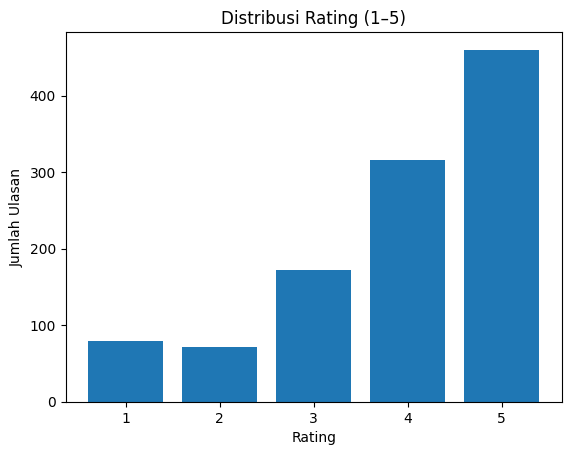

In [28]:
plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Distribusi Rating (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan")
plt.show()


In [29]:
df["char_len"] = df["text_basic"].str.len()
df["word_len"] = df["text_basic"].str.split().apply(len)
df[["char_len", "word_len"]].describe()


,char_len,word_len
count,1100.000000,1100.000000
mean,110.827273,20.051818
std,69.144698,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


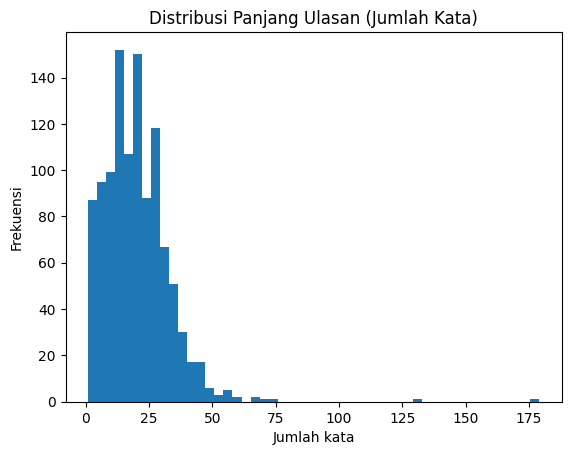

In [30]:
plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


---

## 4. Train/Test Split (Konsisten)

In [31]:
X = df["text_clean"].values
y = df["rating"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi Train:", Counter(y_train))
print("Distribusi Test :", Counter(y_test))


Train: 880 Test: 220
Distribusi Train: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Distribusi Test : Counter({np.int64(5): 92, np.int64(4): 63, np.int64(3): 35, np.int64(1): 16, np.int64(2): 14})


---

## 5. Utilitas Evaluasi

In [32]:
def eval_report(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print()
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def plot_confusion(y_true, y_pred, labels=range(1, 6), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


---

## 6. Helper Model Klasik (TF–IDF)

In [33]:
def fit_tfidf(train_texts, test_texts):
    vec = TfidfVectorizer(lowercase=True, max_features=50000, ngram_range=(1, 2))
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

def train_eval_svm(train_texts, train_labels, test_texts, test_labels, suffix="", class_weight=None):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    svm = LinearSVC(class_weight=class_weight)
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred

def train_eval_nb(train_texts, train_labels, test_texts, test_labels, suffix=""):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    nb = MultinomialNB()
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred


---

## 7. Duplicate Oversampling (Non-Aug, untuk S2)

In [34]:
def duplicate_oversample(texts, labels):
    texts, labels = list(texts), list(labels)
    counts = Counter(labels)
    max_count = max(counts.values())

    idx_by = {c: [] for c in counts}
    for i, y in enumerate(labels):
        idx_by[y].append(i)

    new_texts, new_labels = texts[:], labels[:]

    for c, idxs in idx_by.items():
        need = max_count - counts[c]
        if need <= 0:
            continue
        for _ in range(need):
            i = random.choice(idxs)
            new_texts.append(texts[i])   # teks sama persis
            new_labels.append(c)

    return np.array(new_texts), np.array(new_labels)

print("Train original:", Counter(y_train))
Xt_dup_preview, yt_dup_preview = duplicate_oversample(X_train, y_train)
print("Train after duplicate oversampling (preview):", Counter(yt_dup_preview))


Train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Train after duplicate oversampling (preview): Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


---

## 8. Helper LSTM (PyTorch)

In [35]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def build_vocab(texts, max_vocab=30000, min_freq=2):
    from collections import Counter as CCounter
    counter = CCounter()
    for t in texts:
        counter.update(str(t).split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for w, c in counter.most_common():
        if c < min_freq:
            continue
        if len(vocab) >= max_vocab:
            break
        vocab[w] = len(vocab)
    return vocab

def encode(text, vocab, max_len=200):
    tokens = str(text).split()
    ids = [vocab.get(t, vocab["<unk>"]) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab["<pad>"]] * (max_len - len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=200):
        self.texts = list(texts)
        self.labels = list(labels)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts[idx], self.vocab, self.max_len), dtype=torch.long)
        y = torch.tensor(int(self.labels[idx]) - 1, dtype=torch.long)  # 1-5 -> 0-4
        return x, y

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, num_classes=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)

def train_eval_lstm(
    train_texts, train_labels, test_texts, test_labels,
    epochs=3, max_len=200, batch_size=64, suffix="",
    use_class_weights=False
):
    vocab = build_vocab(train_texts)
    train_ds = TextDataset(train_texts, train_labels, vocab, max_len)
    test_ds  = TextDataset(test_texts, test_labels, vocab, max_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = LSTMClassifier(len(vocab)).to(DEVICE)

    if use_class_weights:
        classes = np.array([1,2,3,4,5])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels))
        class_weights = torch.tensor(cw, dtype=torch.float).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def train_one_epoch():
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total += float(loss.item())
        return total / max(1, len(train_loader))

    def predict():
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                logits = model(xb)
                p = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(list(p))
                trues.extend(list(yb.numpy()))
        preds = np.array(preds) + 1
        trues = np.array(trues) + 1
        return trues, preds

    for ep in range(epochs):
        loss = train_one_epoch()
        print(f"[LSTM{suffix}] Epoch {ep+1}/{epochs} | loss={loss:.4f}")

    yt, yp = predict()
    return eval_report(yt, yp, f"LSTM{suffix}")


---

## 9. Helper Transformer (BERT & DistilBERT) — WeightedTrainer + Output Seragam
Tanpa dependency `evaluate` (biar aman di Colab).

In [36]:
from transformers import EarlyStoppingCallback

In [37]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2
DEFAULT_EPOCHS = 3

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    f1w = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,

        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
    )
    try:
        return TrainingArguments(**common)
    except TypeError:
        # fallback for newer API naming
        common.pop("evaluation_strategy", None)
        common["eval_strategy"] = "epoch"
        return TrainingArguments(**common)


class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs = dict(inputs)
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def _build_trainer(model, args, train_tok, test_tok, tokenizer, use_class_weights, class_weights):
    base_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        compute_metrics=compute_metrics,
    )

    if use_class_weights:
        cls = WeightedTrainer
        base_kwargs["class_weights"] = class_weights
    else:
        cls = Trainer

    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]

    try:
        return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
    except TypeError:
        return cls(**base_kwargs, processing_class=tokenizer, callbacks=callbacks)


def safe_load_sequence_classifier(model_name, num_labels=5):
    # Try avoiding safetensors when supported
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=False
        )
    except TypeError:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        )

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN, out_dir="./tmp_tr", suffix="",
    use_class_weights=False
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = safe_load_sequence_classifier(model_name, num_labels=5)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    train_tok = train_tok.remove_columns(["text"]).rename_column("label", "labels")
    test_tok  = test_tok.remove_columns(["text"]).rename_column("label", "labels")

    args = build_training_args(out_dir, epochs, batch_size)

    class_weights = None
    if use_class_weights:
        classes = np.array([1,2,3,4,5])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels2))
        class_weights = torch.tensor(cw, dtype=torch.float)

    trainer = _build_trainer(
        model=model,
        args=args,
        train_tok=train_tok,
        test_tok=test_tok,
        tokenizer=tokenizer,
        use_class_weights=use_class_weights,
        class_weights=class_weights
    )

    trainer.train()
    res = trainer.evaluate()

    out = {
        "model": model_name + suffix,
        "accuracy": res.get("eval_accuracy"),
        "f1_macro": res.get("eval_f1_macro"),
        "f1_weighted": res.get("eval_f1_weighted"),
        "eval_loss": res.get("eval_loss"),
        "epoch": res.get("epoch"),
    }

    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return out


---

## 10. Augmentasi Kelas Minoritas (Helper S3)

In [38]:
# EDA-style augmentation helpers
def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = new_words = words[:]
    for _ in range(n):
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    if not words:
        return [str(text)] * num_aug
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)

# Optional heavy methods
def backtranslate(text, src_lang="en", mid_lang="fr"):
    try:
        from transformers import MarianMTModel, MarianTokenizer
        model_name_1 = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
        model_name_2 = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"
        tok1 = MarianTokenizer.from_pretrained(model_name_1)
        mod1 = MarianMTModel.from_pretrained(model_name_1)
        tok2 = MarianTokenizer.from_pretrained(model_name_2)
        mod2 = MarianMTModel.from_pretrained(model_name_2)

        def translate(t, tok, mod):
            batch = tok([t], return_tensors="pt", truncation=True, padding=True)
            gen = mod.generate(**batch, max_length=256)
            return tok.batch_decode(gen, skip_special_tokens=True)[0]

        mid = translate(text, tok1, mod1)
        back = translate(mid, tok2, mod2)
        return back
    except Exception:
        return text

def bert_augment(text, num_aug=1):
    try:
        import nlpaug.augmenter.word as naw
        aug = naw.ContextualWordEmbsAug(model_path="bert-base-uncased", action="substitute")
        return aug.augment(text, n=num_aug)
    except Exception:
        return [text] * num_aug

def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=2
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "backtranslation":
                aug_texts = [backtranslate(base) for _ in range(k)]
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)

# Default strategies (ringan)
# AUG_STRATEGIES = ["eda", "modified_eda"]
# Untuk eksperimen lebih berat, uncomment:
AUG_STRATEGIES = ["eda", "modified_eda", "backtranslation", "bert"]

TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 2

print("Distribusi train original:", Counter(y_train))
print("AUG_STRATEGIES:", AUG_STRATEGIES)


Distribusi train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
AUG_STRATEGIES: ['eda', 'modified_eda', 'backtranslation', 'bert']


---

# Skenario 1 — Baseline (Tanpa Penanganan Imbalance)

In [53]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train
)

print("Train base:", Counter(y_train_base))
print("Val       :", Counter(y_val))


Train base: Counter({np.int64(5): 294, np.int64(4): 202, np.int64(3): 110, np.int64(1): 51, np.int64(2): 47})
Val       : Counter({np.int64(5): 74, np.int64(4): 51, np.int64(3): 27, np.int64(1): 13, np.int64(2): 11})


In [18]:
results_s1 = []


## 1.1 Linear SVM (S1)

In [39]:
svm_s1_res, _, _, _ = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)",
    class_weight=None
)
results_s1.append(svm_s1_res)


=== Linear SVM (S1 baseline) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LinearSVC())
])

svm_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [20000, 50000],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

svm_gs = GridSearchCV(
    svm_pipe,
    svm_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,          # ✅ most stable fix
    verbose=1
)

svm_gs.fit(X_train_base, y_train_base)

print("Best SVM params:", svm_gs.best_params_)
print("Best CV f1_macro:", svm_gs.best_score_)


# Validate
svm_val_pred = svm_gs.predict(X_val)
svm_val_res = eval_report(y_val, svm_val_pred, "SVM tuned (VAL)")

# Retrain best on full train, test once
svm_best = svm_gs.best_estimator_
svm_best.fit(X_train, y_train)
svm_test_pred = svm_best.predict(X_test)
svm_test_res = eval_report(y_test, svm_test_pred, "SVM tuned (TEST)")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best SVM params: {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1)}
Best CV f1_macro: 0.33814555268502694
=== SVM tuned (VAL) ===
Accuracy : 0.4318
F1-macro : 0.3328
F1-weight: 0.4205

              precision    recall  f1-score   support

           1     0.3571    0.3846    0.3704        13
           2     0.1250    0.1818    0.1481        11
           3     0.2308    0.2222    0.2264        27
           4     0.3636    0.2353    0.2857        51
           5     0.5862    0.6892    0.6335        74

    accuracy                         0.4318       176
   macro avg     0.3326    0.3426    0.3328       176
weighted avg     0.4214    0.4318    0.4205       176


=== SVM tuned (TEST) ===
Accuracy : 0.4636
F1-macro : 0.3863
F1-weight: 0.4591

              precision    recall  f1-score   support

           1     0.5455    0.3750    0.4444        16
           2     

## 1.2 Naive Bayes (S1)

In [40]:
nb_s1_res, _, _, _ = train_eval_nb(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)


=== Naive Bayes (S1 baseline) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




In [57]:
from sklearn.naive_bayes import MultinomialNB

nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), max_features=50000)),
    ("clf", MultinomialNB())
])

nb_grid = {
    "clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0],
}

nb_gs = GridSearchCV(
    nb_pipe,
    nb_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=1,
    verbose=1
)

nb_gs.fit(X_train_base, y_train_base)

print("Best NB params:", nb_gs.best_params_)
print("Best CV f1_macro:", nb_gs.best_score_)

# Validate
nb_val_pred = nb_gs.predict(X_val)
nb_val_res = eval_report(y_val, nb_val_pred, "NB tuned (VAL)")

# Retrain best on full train, test once
nb_best = nb_gs.best_estimator_
nb_best.fit(X_train, y_train)
nb_test_pred = nb_best.predict(X_test)
nb_test_res = eval_report(y_test, nb_test_pred, "NB tuned (TEST)")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best NB params: {'clf__alpha': 0.1}
Best CV f1_macro: 0.2384218115536518
=== NB tuned (VAL) ===
Accuracy : 0.4886
F1-macro : 0.2818
F1-weight: 0.4361

              precision    recall  f1-score   support

           1     0.5000    0.0769    0.1333        13
           2     0.0000    0.0000    0.0000        11
           3     0.4000    0.1481    0.2162        27
           4     0.3729    0.4314    0.4000        51
           5     0.5619    0.7973    0.6592        74

    accuracy                         0.4886       176
   macro avg     0.3670    0.2907    0.2818       176
weighted avg     0.4426    0.4886    0.4361       176


=== NB tuned (TEST) ===
Accuracy : 0.4636
F1-macro : 0.3028
F1-weight: 0.4157

              precision    recall  f1-score   support

           1     1.0000    0.1250    0.2222        16
           2     1.0000    0.0714    0.1333        14
           3     0.3333    0.1429    0.2000        35
   

## 1.3 LSTM (S1)

In [66]:
from sklearn.linear_model import LogisticRegression

def train_eval_lr(train_texts, train_labels, test_texts, test_labels, suffix="", class_weight=None):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)

    lr = LogisticRegression(
        max_iter=2000,
        class_weight=class_weight,
        n_jobs=None,        # biar aman di Windows
        solver="saga",      # robust utk sparse + multiclass
        multi_class="multinomial"
    )

    lr.fit(Xtr, train_labels)
    pred = lr.predict(Xte)
    res = eval_report(test_labels, pred, f"Logistic Regression{suffix}")
    return res, vec, lr, pred


In [67]:
lr_s1_res, _, _, _ = train_eval_lr(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)",
    class_weight=None
)
results_s1.append(lr_s1_res)

=== Logistic Regression (S1 baseline) ===
Accuracy : 0.4818
F1-macro : 0.2412
F1-weight: 0.4053

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.4545    0.1429    0.2174        35
           4     0.3519    0.3016    0.3248        63
           5     0.5290    0.8913    0.6640        92

    accuracy                         0.4818       220
   macro avg     0.2671    0.2671    0.2412       220
weighted avg     0.3943    0.4818    0.4053       220




c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 1.4 BERT (S1)

In [42]:
try:
    bert_s1_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_bert_s1",
        suffix=" (S1 baseline)",
        use_class_weights=False
    )
    results_s1.append(bert_s1_res)
except Exception as e:
    print("BERT S1 error:", e)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.178200,1.171764,0.522727,0.290627,0.455450
2,0.879400,1.178577,0.559091,0.397201,0.523824
3,0.868200,1.348772,0.577273,0.427096,0.546487


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S1 baseline) ===
{'eval_loss': 1.3487716913223267, 'eval_accuracy': 0.5772727272727273, 'eval_f1_macro': 0.4270963497889969, 'eval_f1_weighted': 0.5464873442954624, 'eval_runtime': 23.0267, 'eval_samples_per_second': 9.554, 'eval_steps_per_second': 4.777, 'epoch': 3.0}



## 1.5 DistilBERT (S1)

In [43]:
try:
    distil_s1_res = train_eval_transformer(
        "distilbert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_distilbert_s1",
        suffix=" (S1 baseline)",
        use_class_weights=False
    )
    results_s1.append(distil_s1_res)
except Exception as e:
    print("DistilBERT S1 error:", e)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.158200,1.129497,0.545455,0.309544,0.491237
2,0.866200,1.172050,0.545455,0.318080,0.503816
3,0.820400,1.251063,0.581818,0.426630,0.552515


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== distilbert-base-uncased (S1 baseline) ===
{'eval_loss': 1.2510628700256348, 'eval_accuracy': 0.5818181818181818, 'eval_f1_macro': 0.4266297428062134, 'eval_f1_weighted': 0.5525147869064981, 'eval_runtime': 21.2635, 'eval_samples_per_second': 10.346, 'eval_steps_per_second': 5.173, 'epoch': 3.0}



### Rekap Skenario 1

In [45]:
from IPython.display import display
import pandas as pd

s1_table = pd.DataFrame(results_s1)

s1_best = (
    s1_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s1_best)


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S1 baseline),0.577273,0.427096,0.546487,1.348772,3.0
1,distilbert-base-uncased (S1 baseline),0.581818,0.426630,0.552515,1.251063,3.0
2,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN,NaN
3,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN,NaN
4,LSTM (S1 baseline),0.418182,0.117949,0.246620,NaN,NaN


---

# Skenario 3 — Balancing **Dengan** Augmentasi Teks
Di sini **augmentasi dipisah per model**.
Tiap model akan:
1) melakukan augment untuk setiap strategi pada `AUG_STRATEGIES`,
2) melatih ulang model,
3) menampilkan rekap khusus model.

## 3.1 Linear SVM (S3 — Augment per Strategi)

In [46]:
results_s3_svm = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | SVM | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    svm_s3_res, _, _, _ = train_eval_svm(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})",
        class_weight=None
    )
    results_s3_svm.append(svm_s3_res)

s3_svm_table = pd.DataFrame(results_s3_svm)
display(s3_svm_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | SVM | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=eda) ===
Accuracy : 0.4455
F1-macro : 0.3533
F1-weight: 0.4403

              precision    recall  f1-score   support

           1     0.3846    0.3125    0.3448        16
           2     0.1818    0.1429    0.1600        14
           3     0.3056    0.3143    0.3099        35
           4     0.3226    0.3175    0.3200        63
           5     0.6122    0.6522    0.6316        92

    accuracy                         0.4455       220
   macro avg     0.3614    0.3479    0.3533       220
weighted avg     0.4366    0.4455    0.4403       220



------------------------------------------------------------
S3 | SVM | Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.

The following layers were not sharded: bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, cls.predictions.transform.dense.bias, cls.predictions.decoder.bias, cls.predictions.decoder.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.LayerNorm.weight, cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.output.dense.weight, cls.predictions.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, cls.predictions.transform.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output

Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=bert) ===
Accuracy : 0.4636
F1-macro : 0.3695
F1-weight: 0.457

              precision    recall  f1-score   support

           1     0.4000    0.3750    0.3871        16
           2     0.1429    0.1429    0.1429        14
           3     0.3438    0.3143    0.3284        35
           4     0.3684    0.3333    0.3500        63
           5     0.6078    0.6739    0.6392        92

    accuracy                         0.4636       220
   macro avg     0.3726    0.3679    0.3695       220
weighted avg     0.4526    0.4636    0.4570       220




,model,accuracy,f1_macro,f1_weighted
1,Linear SVM (S3 aug=modified_eda),0.472727,0.377363,0.463659
2,Linear SVM (S3 aug=backtranslation),0.472727,0.376480,0.461487
3,Linear SVM (S3 aug=bert),0.463636,0.369497,0.457001
0,Linear SVM (S3 aug=eda),0.445455,0.353253,0.440307


## 3.2 Naive Bayes (S3 — Augment per Strategi)

In [47]:
results_s3_nb = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | NB | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    nb_s3_res, _, _, _ = train_eval_nb(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})"
    )
    results_s3_nb.append(nb_s3_res)

s3_nb_table = pd.DataFrame(results_s3_nb)
display(s3_nb_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | NB | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Naive Bayes (S3 aug=eda) ===
Accuracy : 0.4727
F1-macro : 0.4221
F1-weight: 0.4842

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000        16
           2     0.1724    0.3571    0.2326        14
           3     0.3415    0.4000    0.3684        35
           4     0.3962    0.3333    0.3621        63
           5     0.6914    0.6087    0.6474        92

    accuracy                         0.4727       220
   macro avg     0.4203    0.4398    0.4221       220
weighted avg     0.5042    0.4727    0.4842       220



------------------------------------------------------------
S3 | NB | Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.i

,model,accuracy,f1_macro,f1_weighted
0,Naive Bayes (S3 aug=eda),0.472727,0.422089,0.484189
3,Naive Bayes (S3 aug=bert),0.477273,0.392419,0.469963
1,Naive Bayes (S3 aug=modified_eda),0.450000,0.390780,0.467503
2,Naive Bayes (S3 aug=backtranslation),0.427273,0.380640,0.447061


## 3.3 LSTM (S3 — Augment per Strategi)

In [48]:
results_s3_lstm = []

for strat in AUG_STRATEGIES:
    try:
        print("\n" + "-"*60)
        print("S3 | LSTM | Strategy:", strat)
        Xa, ya = augment_minority(
            X_train, y_train,
            strategy=strat,
            target_multiplier=TARGET_MULTIPLIER,
            max_aug_per_sample=MAX_AUG_PER_SAMPLE
        )
        print("Distribusi train after aug:", Counter(ya))

        lstm_s3_res = train_eval_lstm(
            Xa, ya, X_test, y_test,
            epochs=3, suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_lstm.append(lstm_s3_res)
    except Exception as e:
        print(f"LSTM S3 ({strat}) error:", e)

s3_lstm_table = pd.DataFrame(results_s3_lstm)
display(s3_lstm_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | LSTM | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
[LSTM (S3 aug=eda)] Epoch 1/3 | loss=1.6109
[LSTM (S3 aug=eda)] Epoch 2/3 | loss=1.6102
[LSTM (S3 aug=eda)] Epoch 3/3 | loss=1.6109
=== LSTM (S3 aug=eda) ===
Accuracy : 0.1591
F1-macro : 0.0549
F1-weight: 0.0437

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.1591    1.0000    0.2745        35
           4     0.0000    0.0000    0.0000        63
           5     0.0000    0.0000    0.0000        92

    accuracy                         0.1591       220
   macro avg     0.0318    0.2000    0.0549       220
weighted avg     0.0253    0.1591    0.0437       220



------------------------------------------------------------
S3 | LSTM | Strateg

,model,accuracy,f1_macro,f1_weighted
2,LSTM (S3 aug=backtranslation),0.418182,0.117949,0.246620
1,LSTM (S3 aug=modified_eda),0.286364,0.089046,0.127498
0,LSTM (S3 aug=eda),0.159091,0.054902,0.043672
3,LSTM (S3 aug=bert),0.159091,0.054902,0.043672


In [68]:
results_s3_lr = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | LR | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    lr_s3_res, _, _, _ = train_eval_lr(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})"
    )
    results_s3_lr.append(lr_s3_res)

s3_lr_table = pd.DataFrame(results_s3_lr)
display(s3_lr_table.sort_values("f1_macro", ascending=False))


------------------------------------------------------------
S3 | LR | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Logistic Regression (S3 aug=eda) ===
Accuracy : 0.4818
F1-macro : 0.39
F1-weight: 0.4767

              precision    recall  f1-score   support

           1     0.4615    0.3750    0.4138        16
           2     0.1875    0.2143    0.2000        14
           3     0.3056    0.3143    0.3099        35
           4     0.3636    0.3175    0.3390        63
           5     0.6600    0.7174    0.6875        92

    accuracy                         0.4818       220
   macro avg     0.3956    0.3877    0.3900       220
weighted avg     0.4742    0.4818    0.4767       220



------------------------------------------------------------
S3 | LR | Strategy: modified_eda


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=modified_eda) ===
Accuracy : 0.5091
F1-macro : 0.4347
F1-weight: 0.5072

              precision    recall  f1-score   support

           1     0.5000    0.4375    0.4667        16
           2     0.2353    0.2857    0.2581        14
           3     0.3714    0.3714    0.3714        35
           4     0.4211    0.3810    0.4000        63
           5     0.6598    0.6957    0.6772        92

    accuracy                         0.5091       220
   macro avg     0.4375    0.4342    0.4347       220
weighted avg     0.5069    0.5091    0.5072       220



------------------------------------------------------------
S3 | LR | Strategy: backtranslation
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=backtranslation) ===
Accuracy : 0.4591
F1-macro : 0.3703
F1-weight: 0.4552

              precision    recall  f1-score   support

           1     0.4615    0.3750    0.4138        16
           2     0.1176    0.1429    0.1290        14
           3     0.3333    0.3429    0.3380        35
           4     0.3519    0.3016    0.3248        63
           5     0.6200    0.6739    0.6458        92

    accuracy                         0.4591       220
   macro avg     0.3769    0.3672    0.3703       220
weighted avg     0.4541    0.4591    0.4552       220



------------------------------------------------------------
S3 | LR | Strategy: bert
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=bert) ===
Accuracy : 0.4818
F1-macro : 0.4097
F1-weight: 0.4793

              precision    recall  f1-score   support

           1     0.5385    0.4375    0.4828        16
           2     0.1667    0.2143    0.1875        14
           3     0.4062    0.3714    0.3881        35
           4     0.3448    0.3175    0.3306        63
           5     0.6364    0.6848    0.6597        92

    accuracy                         0.4818       220
   macro avg     0.4185    0.4051    0.4097       220
weighted avg     0.4793    0.4818    0.4793       220




,model,accuracy,f1_macro,f1_weighted
1,Logistic Regression (S3 aug=modified_eda),0.509091,0.434682,0.507211
3,Logistic Regression (S3 aug=bert),0.481818,0.409717,0.479313
0,Logistic Regression (S3 aug=eda),0.481818,0.390027,0.476690
2,Logistic Regression (S3 aug=backtranslation),0.459091,0.370295,0.455165


## 3.4 BERT (S3 — Augment per Strategi)

In [49]:
results_s3_bert = []

for strat in AUG_STRATEGIES:
    try:
        print("\n" + "-"*60)
        print("S3 | BERT | Strategy:", strat)
        Xa, ya = augment_minority(
            X_train, y_train,
            strategy=strat,
            target_multiplier=TARGET_MULTIPLIER,
            max_aug_per_sample=MAX_AUG_PER_SAMPLE
        )
        print("Distribusi train after aug:", Counter(ya))

        bert_s3_res = train_eval_transformer(
            "bert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_bert_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_bert.append(bert_s3_res)
    except Exception as e:
        print(f"BERT S3 ({strat}) error:", e)

s3_bert_table = pd.DataFrame(results_s3_bert)
display(s3_bert_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | BERT | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.output.dense.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.909000,1.386487,0.518182,0.362407,0.473853
2,0.493300,2.183669,0.504545,0.385537,0.499884
3,0.245100,2.454143,0.527273,0.391515,0.518081


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=eda) ===
{'eval_loss': 2.4541425704956055, 'eval_accuracy': 0.5272727272727272, 'eval_f1_macro': 0.3915154118327493, 'eval_f1_weighted': 0.5180814154885361, 'eval_runtime': 21.5204, 'eval_samples_per_second': 10.223, 'eval_steps_per_second': 5.111, 'epoch': 3.0}


------------------------------------------------------------
S3 | BERT | Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.output.dense.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.908200,1.453806,0.522727,0.382219,0.490945
2,0.462800,2.258558,0.536364,0.375182,0.515380


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 1.4538058042526245, 'eval_accuracy': 0.5227272727272727, 'eval_f1_macro': 0.3822191029644981, 'eval_f1_weighted': 0.4909453926255095, 'eval_runtime': 22.1799, 'eval_samples_per_second': 9.919, 'eval_steps_per_second': 4.959, 'epoch': 2.0}


------------------------------------------------------------
S3 | BERT | Strategy: backtranslation
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.output.dense.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.779000,1.478938,0.495455,0.311971,0.469943
2,0.573200,2.210000,0.513636,0.359147,0.494484
3,0.201500,2.698585,0.522727,0.377247,0.509995


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 2.698585271835327, 'eval_accuracy': 0.5227272727272727, 'eval_f1_macro': 0.37724663294084726, 'eval_f1_weighted': 0.5099954211074895, 'eval_runtime': 21.1503, 'eval_samples_per_second': 10.402, 'eval_steps_per_second': 5.201, 'epoch': 3.0}


------------------------------------------------------------
S3 | BERT | Strategy: bert
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.position_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.self.key.bias, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.output.dense.bias, bert.pooler.dense.weight, classifier.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.323900,1.170442,0.513636,0.384150,0.482230
2,0.747300,1.629745,0.490909,0.389370,0.482820
3,0.333000,2.197634,0.513636,0.430704,0.514529


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=bert) ===
{'eval_loss': 2.197633743286133, 'eval_accuracy': 0.5136363636363637, 'eval_f1_macro': 0.43070413755159526, 'eval_f1_weighted': 0.514528580969259, 'eval_runtime': 22.1564, 'eval_samples_per_second': 9.929, 'eval_steps_per_second': 4.965, 'epoch': 3.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
3,bert-base-uncased (S3 aug=bert),0.513636,0.430704,0.514529,2.197634,3.0
0,bert-base-uncased (S3 aug=eda),0.527273,0.391515,0.518081,2.454143,3.0
1,bert-base-uncased (S3 aug=modified_eda),0.522727,0.382219,0.490945,1.453806,2.0
2,bert-base-uncased (S3 aug=backtranslation),0.522727,0.377247,0.509995,2.698585,3.0


## 3.5 DistilBERT (S3 — Augment per Strategi)

In [50]:
results_s3_distil = []

for strat in AUG_STRATEGIES:
    try:
        print("\n" + "-"*60)
        print("S3 | DistilBERT | Strategy:", strat)
        Xa, ya = augment_minority(
            X_train, y_train,
            strategy=strat,
            target_multiplier=TARGET_MULTIPLIER,
            max_aug_per_sample=MAX_AUG_PER_SAMPLE
        )
        print("Distribusi train after aug:", Counter(ya))

        distil_s3_res = train_eval_transformer(
            "distilbert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_distilbert_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_distil.append(distil_s3_res)
    except Exception as e:
        print(f"DistilBERT S3 ({strat}) error:", e)

s3_distil_table = pd.DataFrame(results_s3_distil)
display(s3_distil_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | DistilBERT | Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, classifier.bias, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.tra

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.947300,1.244315,0.527273,0.418426,0.517187
2,0.599100,1.741582,0.504545,0.431919,0.507991
3,0.366300,1.971937,0.554545,0.479856,0.555061


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== distilbert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.9719372987747192, 'eval_accuracy': 0.5545454545454546, 'eval_f1_macro': 0.4798564609755135, 'eval_f1_weighted': 0.5550608546258945, 'eval_runtime': 11.6469, 'eval_samples_per_second': 18.889, 'eval_steps_per_second': 9.445, 'epoch': 3.0}


------------------------------------------------------------
S3 | DistilBERT | Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, classifier.bias, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.tra

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.926000,1.209728,0.550000,0.425323,0.521106
2,0.653700,1.855112,0.540909,0.434028,0.532866
3,0.310000,2.122706,0.545455,0.440164,0.544512


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== distilbert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 2.122706174850464, 'eval_accuracy': 0.5454545454545454, 'eval_f1_macro': 0.44016367063268813, 'eval_f1_weighted': 0.5445119662013005, 'eval_runtime': 11.5524, 'eval_samples_per_second': 19.044, 'eval_steps_per_second': 9.522, 'epoch': 3.0}


------------------------------------------------------------
S3 | DistilBERT | Strategy: backtranslation
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, classifier.bias, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.tra

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.776500,1.481464,0.472727,0.346202,0.469821
2,0.607300,1.931003,0.536364,0.435818,0.535759
3,0.271100,2.231638,0.527273,0.419139,0.526569


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== distilbert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.9310028553009033, 'eval_accuracy': 0.5363636363636364, 'eval_f1_macro': 0.4358176174521686, 'eval_f1_weighted': 0.5357587267768955, 'eval_runtime': 11.6107, 'eval_samples_per_second': 18.948, 'eval_steps_per_second': 9.474, 'epoch': 3.0}


------------------------------------------------------------
S3 | DistilBERT | Strategy: bert
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, classifier.bias, classifier.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.tra

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36440\3575509826.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.169800,1.145289,0.522727,0.473038,0.526338
2,0.806700,1.674804,0.472727,0.374616,0.472064


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== distilbert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.1452891826629639, 'eval_accuracy': 0.5227272727272727, 'eval_f1_macro': 0.47303775849195767, 'eval_f1_weighted': 0.5263382251384536, 'eval_runtime': 11.5528, 'eval_samples_per_second': 19.043, 'eval_steps_per_second': 9.522, 'epoch': 2.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,distilbert-base-uncased (S3 aug=eda),0.554545,0.479856,0.555061,1.971937,3.0
3,distilbert-base-uncased (S3 aug=bert),0.522727,0.473038,0.526338,1.145289,2.0
1,distilbert-base-uncased (S3 aug=modified_eda),0.545455,0.440164,0.544512,2.122706,3.0
2,distilbert-base-uncased (S3 aug=backtranslation),0.536364,0.435818,0.535759,1.931003,3.0


### Rekap Skenario 3 (Gabungan Semua Model)

In [69]:
results_s3 = []
if 'results_s3_svm' in globals(): results_s3 += results_s3_svm
if 'results_s3_nb' in globals(): results_s3 += results_s3_nb
if 'results_s3_lstm' in globals(): results_s3 += results_s3_lstm
if 'results_s3_bert' in globals(): results_s3 += results_s3_bert
if 'results_s3_distil' in globals(): results_s3 += results_s3_distil
if 'results_s3_lr' in globals(): results_s3 += results_s3_lr

s3_table = pd.DataFrame(results_s3)
display(s3_table.sort_values("f1_macro", ascending=False))


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
16,distilbert-base-uncased (S3 aug=eda),0.554545,0.479856,0.555061,1.971937,3.0
19,distilbert-base-uncased (S3 aug=bert),0.522727,0.473038,0.526338,1.145289,2.0
17,distilbert-base-uncased (S3 aug=modified_eda),0.545455,0.440164,0.544512,2.122706,3.0
18,distilbert-base-uncased (S3 aug=backtranslation),0.536364,0.435818,0.535759,1.931003,3.0
21,Logistic Regression (S3 aug=modified_eda),0.509091,0.434682,0.507211,NaN,NaN
15,bert-base-uncased (S3 aug=bert),0.513636,0.430704,0.514529,2.197634,3.0
4,Naive Bayes (S3 aug=eda),0.472727,0.422089,0.484189,NaN,NaN
23,Logistic Regression (S3 aug=bert),0.481818,0.409717,0.479313,NaN,NaN
7,Naive Bayes (S3 aug=bert),0.477273,0.392419,0.469963,NaN,NaN
12,bert-base-uncased (S3 aug=eda),0.527273,0.391515,0.518081,2.454143,3.0


---

## 13. Rekap Per Skenario & Summary Akhir (Seragam)

In [70]:
def pick_cols(df_):
    cols = ["model", "accuracy", "f1_macro", "f1_weighted"]
    if "eval_loss" in df_.columns:
        cols.append("eval_loss")
    return df_[cols].copy()

s1_clean = pick_cols(s1_table) if 's1_table' in globals() else pd.DataFrame()
s3_clean = pick_cols(s3_table) if 's3_table' in globals() else pd.DataFrame()

print("S1 (baseline):")
display(s1_clean.sort_values("f1_macro", ascending=False) if not s1_clean.empty else s1_clean)
print("\nS3 (aug):")
display(s3_clean.sort_values("f1_macro", ascending=False) if not s3_clean.empty else s3_clean)

summary = pd.concat([s1_clean, s3_clean], ignore_index=True) if not (s1_clean.empty and s3_clean.empty) else pd.DataFrame()
summary = summary.sort_values("f1_macro", ascending=False) if not summary.empty else summary

print("\nSUMMARY:")
display(summary)


S1 (baseline):


,model,accuracy,f1_macro,f1_weighted,eval_loss
7,bert-base-uncased (S1 baseline),0.577273,0.427096,0.546487,1.348772
8,distilbert-base-uncased (S1 baseline),0.581818,0.426630,0.552515,1.251063
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN
4,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN
3,bert-base-uncased (S1 baseline),0.486364,0.210667,0.400061,1.147912
5,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN
2,LSTM (S1 baseline),0.418182,0.117949,0.246620,NaN
6,LSTM (S1 baseline),0.418182,0.117949,0.246620,NaN



S3 (aug):


,model,accuracy,f1_macro,f1_weighted,eval_loss
16,distilbert-base-uncased (S3 aug=eda),0.554545,0.479856,0.555061,1.971937
19,distilbert-base-uncased (S3 aug=bert),0.522727,0.473038,0.526338,1.145289
17,distilbert-base-uncased (S3 aug=modified_eda),0.545455,0.440164,0.544512,2.122706
18,distilbert-base-uncased (S3 aug=backtranslation),0.536364,0.435818,0.535759,1.931003
21,Logistic Regression (S3 aug=modified_eda),0.509091,0.434682,0.507211,NaN
15,bert-base-uncased (S3 aug=bert),0.513636,0.430704,0.514529,2.197634
4,Naive Bayes (S3 aug=eda),0.472727,0.422089,0.484189,NaN
23,Logistic Regression (S3 aug=bert),0.481818,0.409717,0.479313,NaN
7,Naive Bayes (S3 aug=bert),0.477273,0.392419,0.469963,NaN
12,bert-base-uncased (S3 aug=eda),0.527273,0.391515,0.518081,2.454143



SUMMARY:


,model,accuracy,f1_macro,f1_weighted,eval_loss
25,distilbert-base-uncased (S3 aug=eda),0.554545,0.479856,0.555061,1.971937
28,distilbert-base-uncased (S3 aug=bert),0.522727,0.473038,0.526338,1.145289
26,distilbert-base-uncased (S3 aug=modified_eda),0.545455,0.440164,0.544512,2.122706
27,distilbert-base-uncased (S3 aug=backtranslation),0.536364,0.435818,0.535759,1.931003
30,Logistic Regression (S3 aug=modified_eda),0.509091,0.434682,0.507211,NaN
24,bert-base-uncased (S3 aug=bert),0.513636,0.430704,0.514529,2.197634
7,bert-base-uncased (S1 baseline),0.577273,0.427096,0.546487,1.348772
8,distilbert-base-uncased (S1 baseline),0.581818,0.426630,0.552515,1.251063
13,Naive Bayes (S3 aug=eda),0.472727,0.422089,0.484189,NaN
32,Logistic Regression (S3 aug=bert),0.481818,0.409717,0.479313,NaN


---

## 14. Template Narasi Singkat (Opsional)
- **S1**: baseline natural (tanpa penanganan imbalance) untuk 5 arsitektur.
- **S2**: menguji efektivitas penanganan imbalance **non-semantic** tanpa mengubah teks.
- **S3**: menguji apakah augmentasi teks memberikan peningkatan tambahan di atas balancing non-aug.  
  Di notebook ini, **S3 dipecah per model**, jadi kamu bisa membandingkan efek EDA vs Modified EDA
  untuk setiap arsitektur secara rapi.